In [1]:
import datetime
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

# Open the data file from Plenticore Inverter (measured data)

The datafile will be opened and adapted to fit the required formats.

In [2]:
#data_file = os.path.join(os.getcwd(), "pv_data", "2021_q1.csv")
data_file = os.path.join(os.getcwd(), "pv_data", "2021_04_06.csv")
mydf = pd.read_csv(data_file, skiprows=6, delimiter="\t", index_col="Zeit")
mydf.index = pd.to_datetime(mydf.index, unit='s')
mydf.index = mydf.index.tz_localize('UTC')# + pd.offsets.Hour(1)
mydf.index = mydf.index.tz_convert('Europe/Berlin')
mydf = mydf[mydf["DC1 U"].notna()]
mydf = mydf[mydf["DC1 U"].notna()]
mydf["DC1_I_A"] = mydf["DC1 I"] / 1000.0   # convert from mA to ampere
mydf["DC2_I_A"] = mydf["DC2 I"] / 1000.0   # convert from mA to ampere
mydf["ALL_AC_POWER"] = mydf["DC1 P"] + mydf["DC2 P"]
mydf["Consumption"] = mydf["HC2 P"] + mydf["HC2 P"]


In [3]:
pv_gen_hourly = mydf.groupby(pd.Grouper(freq='H', closed='right')).mean()

# Open the forecast data

In [4]:
data_file = os.path.join(os.getcwd(), "output", "2021_04_06_08_01_Uhr.csv")

forecast_data = pd.read_csv(data_file, index_col="date")
forecast_data.index = pd.to_datetime(forecast_data.index)
#for column in forecast_data.columns:
#    print(column)

# Viusalize daza
## Overall power output

In [5]:
today = datetime.date.today()#+ datetime.timedelta(days=1)
start = datetime.datetime(year=today.year, month=today.month, day=today.day, hour=5)
start = pd.Timestamp(start).tz_localize('utc')
end = datetime.datetime(year=today.year, month=today.month, day=today.day, hour=23)
end = pd.Timestamp(end).tz_localize('utc')
data_pv_h = pv_gen_hourly.loc[start:end]
data_pv_overall = mydf.loc[start:end]
forecast_h = forecast_data.loc[start:end]


## Overall power output

<AxesSubplot:title={'center':'Generated and forecasted Power vs. Consumption'}, xlabel='Time', ylabel='Power [W]'>

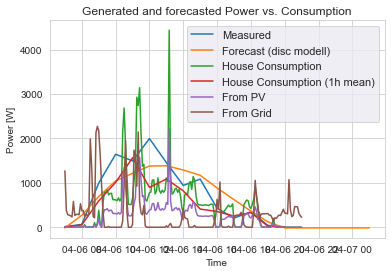

In [6]:
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax.set_xlabel("Time") 
ax.set_ylabel("Power [W]")
ax.set_title("Generated and forecasted Power vs. Consumption")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="Zeit", y="ALL_AC_POWER", data=data_pv_h, label="Measured", ax=ax)
sns.lineplot(x=forecast_h.index, y="ALL_AC_POWER_disc", data=forecast_h, label="Forecast (disc modell)", ax=ax)
sns.lineplot(x="Zeit", y="Consumption", data=data_pv_overall, label="House Consumption", ax=ax)
sns.lineplot(x="Zeit", y="Consumption", data=data_pv_h, label="House Consumption (1h mean)", ax=ax)
sns.lineplot(x="Zeit", y="HC2 P", data=data_pv_overall, label="From PV", ax=ax)
sns.lineplot(x="Zeit", y="HC3 P", data=data_pv_overall, label="From Grid", ax=ax)

<AxesSubplot:title={'center':'Comparison of forecast models'}, xlabel='Time', ylabel='Power [W]'>

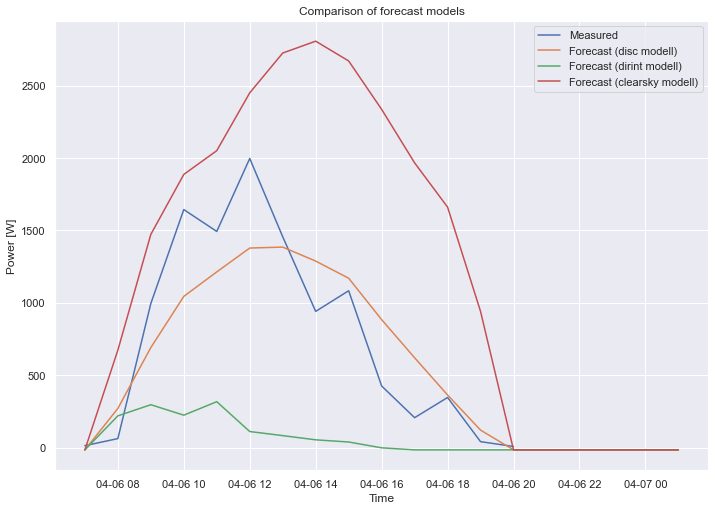

In [7]:
fig, ax = plt.subplots()
ax.set_xlabel("Time") 
ax.set_ylabel("Power [W]")
ax.set_title("Comparison of forecast models")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="Zeit", y="ALL_AC_POWER", data=data_pv_h, label="Measured", ax=ax)
sns.lineplot(x=forecast_h.index, y="ALL_AC_POWER_disc", data=forecast_h, label="Forecast (disc modell)", ax=ax)
sns.lineplot(x=forecast_h.index, y="ALL_AC_POWER_dirint", data=forecast_h, label="Forecast (dirint modell)", ax=ax)
sns.lineplot(x=forecast_h.index, y="ALL_AC_POWER_clearsky", data=forecast_h, label="Forecast (clearsky modell)", ax=ax)

## Power per String


<AxesSubplot:title={'center':'Generated and forecasted Power by String'}, xlabel='Time', ylabel='Power [W]'>

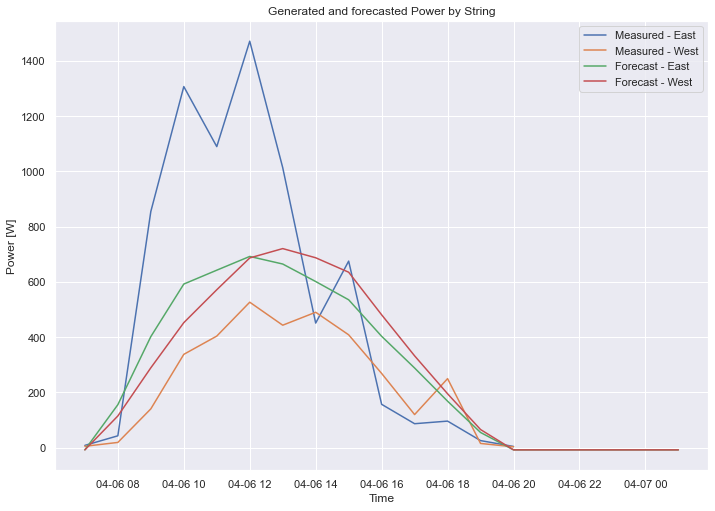

In [8]:
fig, ax = plt.subplots()
ax.set_xlabel("Time") 
ax.set_ylabel("Power [W]")
ax.set_title("Generated and forecasted Power by String")
sns.lineplot(x="Zeit", y="DC2 P", data=data_pv_h, label="Measured - East", ax=ax)
sns.lineplot(x="Zeit", y="DC1 P", data=data_pv_h, label="Measured - West", ax=ax)
sns.lineplot(x=forecast_h.index, y="Ost_ac_disc", data=forecast_h, label="Forecast - East", ax=ax)
sns.lineplot(x=forecast_h.index, y="West_ac_disc", data=forecast_h, label="Forecast - West", ax=ax)

## Realized Production

<AxesSubplot:title={'center':'Generation vs. Forecasted generation'}, xlabel='Type', ylabel='value'>

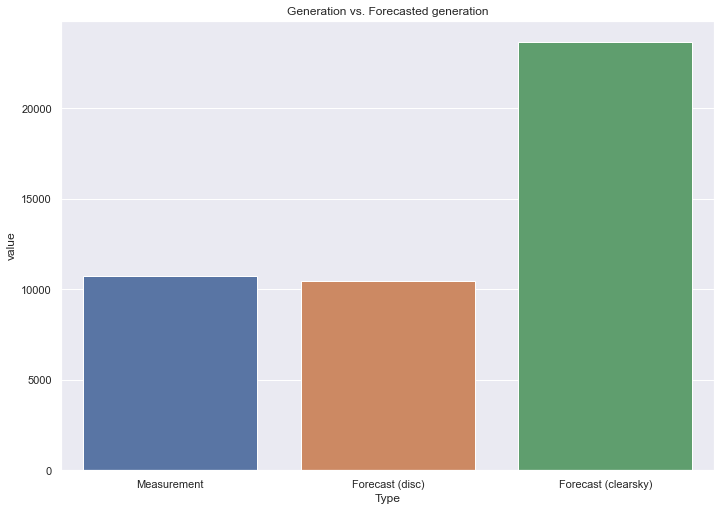

In [9]:
fig, ax = plt.subplots()
ax.set_xlabel("") 
ax.set_ylabel("Generation [Wh]")
ax.set_title("Generation vs. Forecasted generation")
overall_production = data_pv_h["ALL_AC_POWER"].loc[data_pv_h["ALL_AC_POWER"] > 0].sum()
clearsky_forecast = forecast_h["ALL_AC_POWER_clearsky"].loc[forecast_h["ALL_AC_POWER_clearsky"] > 0].sum()
overall_forecast = forecast_h["ALL_AC_POWER_disc"].loc[forecast_h["ALL_AC_POWER_disc"] > 0].sum()
overall = pd.DataFrame({'Type': ["Measurement", "Forecast (disc)", "Forecast (clearsky)"],
                        "value": [overall_production, overall_forecast, clearsky_forecast]})


sns.barplot(x="Type", y="value", data=overall)

## Production summary

### Overall

In [10]:
print(f"Prodution realized:   {overall_production / 1000} kWh")
print(f"Prodution forecasted: {overall_forecast / 1000} kWh (disc modell)")


print(f"Prodution forecasted: {clearsky_forecast / 1000} kWh (clearsky model)")

Prodution realized:   10.71422843822844 kWh
Prodution forecasted: 10.43123687713013 kWh (disc modell)
Prodution forecasted: 23.647729580605347 kWh (clearsky model)


### East

In [11]:
val = data_pv_h["DC2 P"].loc[data_pv_h["DC2 P"] > 0].sum()
print(f"Prodution realized:   {val / 1000} kWh")
val = forecast_h["Ost_ac_disc"].loc[forecast_h["Ost_ac_disc"] > 0].sum()
print(f"Prodution forecasted: {val / 1000} kWh  (disc model)")


Prodution realized:   7.2828339160839155 kWh
Prodution forecasted: 5.199968464868733 kWh  (disc model)


### West

In [12]:
val = data_pv_h["DC1 P"].loc[data_pv_h["DC1 P"] > 0].sum()
print(f"Prodution realized:   {val / 1000} kWh")
val = forecast_h["West_ac_disc"].loc[forecast_h["West_ac_disc"] > 0].sum()
print(f"Prodution forecasted: {val / 1000} kWh")

Prodution realized:   3.4313945221445223 kWh
Prodution forecasted: 5.231268412261397 kWh


## DC Properties
### Voltage

<AxesSubplot:title={'center':'Currents per String - Forecast vs. Measurement'}, xlabel='Time', ylabel='Current [V]'>

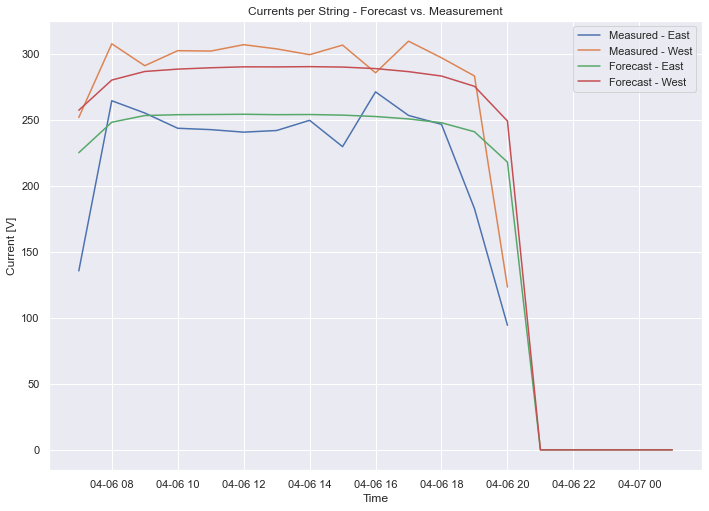

In [13]:
fig, ax = plt.subplots()
ax.set_xlabel("Time") 
ax.set_ylabel("Current [V]")
ax.set_title("Currents per String - Forecast vs. Measurement")
sns.lineplot(x="Zeit", y="DC2 U", data=data_pv_h, label="Measured - East")
sns.lineplot(x="Zeit", y="DC1 U", data=data_pv_h, label="Measured - West")
sns.lineplot(x=forecast_h.index, y="Ost_dc_v_mp_disc", data=forecast_h, label="Forecast - East")
sns.lineplot(x=forecast_h.index, y="West_dc_v_mp_disc", data=forecast_h, label="Forecast - West")

<AxesSubplot:title={'center':'Currents per String - Forecast vs. Measurement - different resolution'}, xlabel='Time', ylabel='Current [V]'>

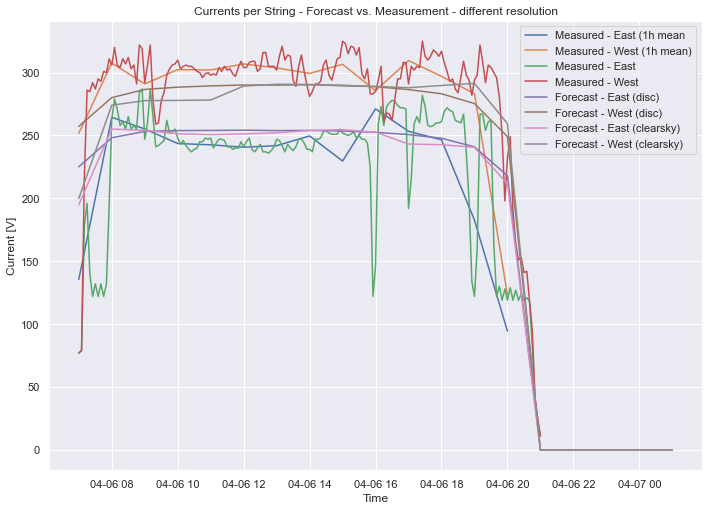

In [14]:
fig, ax = plt.subplots()
ax.set_xlabel("Time") 
ax.set_ylabel("Current [V]")
ax.set_title("Currents per String - Forecast vs. Measurement - different resolution")
sns.lineplot(x="Zeit", y="DC2 U", data=data_pv_h, label="Measured - East (1h mean")
sns.lineplot(x="Zeit", y="DC1 U", data=data_pv_h, label="Measured - West (1h mean)")
sns.lineplot(x="Zeit", y="DC2 U", data=data_pv_overall, label="Measured - East")
sns.lineplot(x="Zeit", y="DC1 U", data=data_pv_overall, label="Measured - West")
sns.lineplot(x=forecast_h.index, y="Ost_dc_v_mp_disc", data=forecast_h, label="Forecast - East (disc)")
sns.lineplot(x=forecast_h.index, y="West_dc_v_mp_disc", data=forecast_h, label="Forecast - West (disc)")
sns.lineplot(x=forecast_h.index, y="Ost_dc_v_mp_clearsky", data=forecast_h, label="Forecast - East (clearsky)")
sns.lineplot(x=forecast_h.index, y="West_dc_v_mp_clearsky", data=forecast_h, label="Forecast - West (clearsky)")

### Amperage

<AxesSubplot:title={'center':'Amperage per String - Forecast vs. Measurement - different resolution'}, xlabel='Time', ylabel='Amperage [A]'>

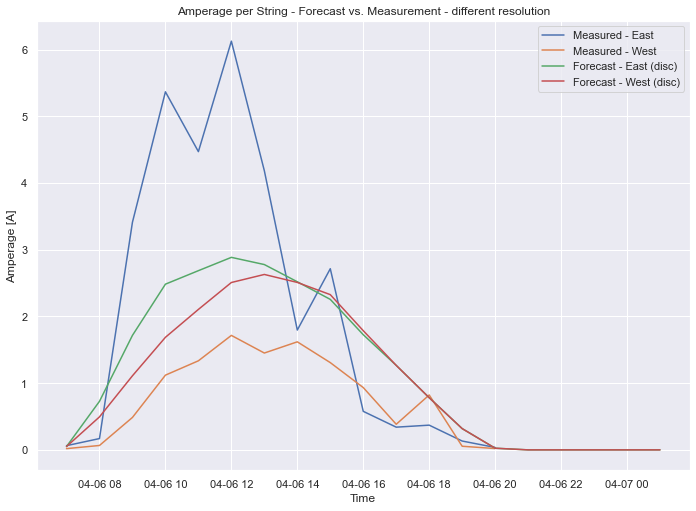

In [15]:
fig, ax = plt.subplots()
ax.set_xlabel("Time") 
ax.set_ylabel("Amperage [A]")
ax.set_title("Amperage per String - Forecast vs. Measurement - different resolution")
sns.lineplot(x="Zeit", y="DC2_I_A", data=data_pv_h, label="Measured - East")
sns.lineplot(x="Zeit", y="DC1_I_A", data=data_pv_h, label="Measured - West")
sns.lineplot(x=forecast_h.index, y="Ost_dc_i_mp_disc", data=forecast_h, label="Forecast - East (disc)")
sns.lineplot(x=forecast_h.index, y="West_dc_i_mp_disc", data=forecast_h, label="Forecast - West (disc)")

## Wheater and Irradiance
### Module temperature

<AxesSubplot:title={'center':'Air temperature vs. forecasted module temperature'}, xlabel='Time', ylabel='Temperature [degC]'>

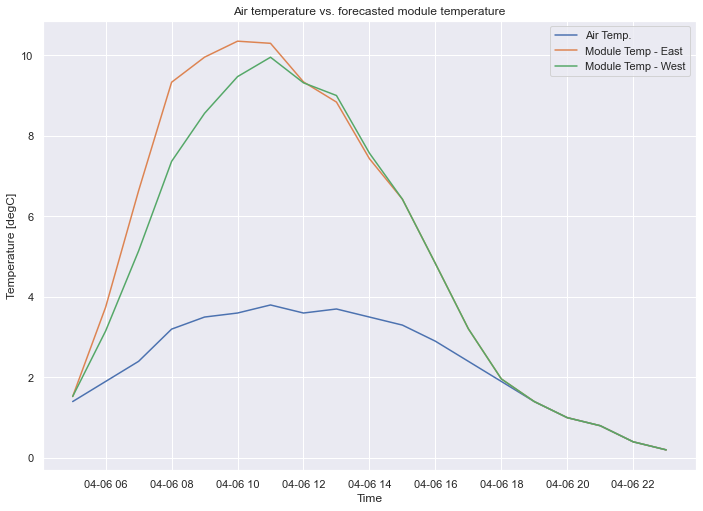

In [16]:
fig, ax = plt.subplots()
ax.set_xlabel("Time") 
ax.set_ylabel("Temperature [degC]")
ax.set_title("Air temperature vs. forecasted module temperature")
sns.lineplot(x=forecast_h.index, y="TEMPERATURE_AIR_200DEGC", data=forecast_h, label="Air Temp.")
sns.lineplot(x=forecast_h.index, y="Ost_cell_temperature_disc", data=forecast_h, label="Module Temp - East")
sns.lineplot(x=forecast_h.index, y="West_cell_temperature_disc", data=forecast_h, label="Module Temp - West")

# Irradiance
## Global Irradiance

<AxesSubplot:title={'center':'Global Irradiance'}, xlabel='Time', ylabel='Gloabel Irradiance [W/m²]'>

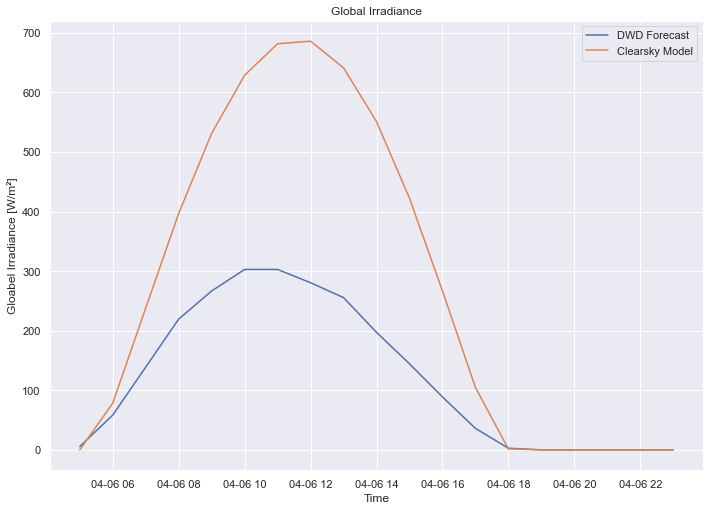

In [17]:
fig, ax = plt.subplots()
ax.set_xlabel("Time") 
ax.set_ylabel("Gloabel Irradiance [W/m²]")
ax.set_title("Global Irradiance")
sns.lineplot(x=forecast_h.index, y="RAD_WH", data=forecast_h, label="DWD Forecast")
sns.lineplot(x=forecast_h.index, y="GHI_CLEARSKY", data=forecast_h, label="Clearsky Model")

<AxesSubplot:title={'center':'GHI, DNI and DHI'}, xlabel='Time', ylabel='Irradiance [W/m²]'>

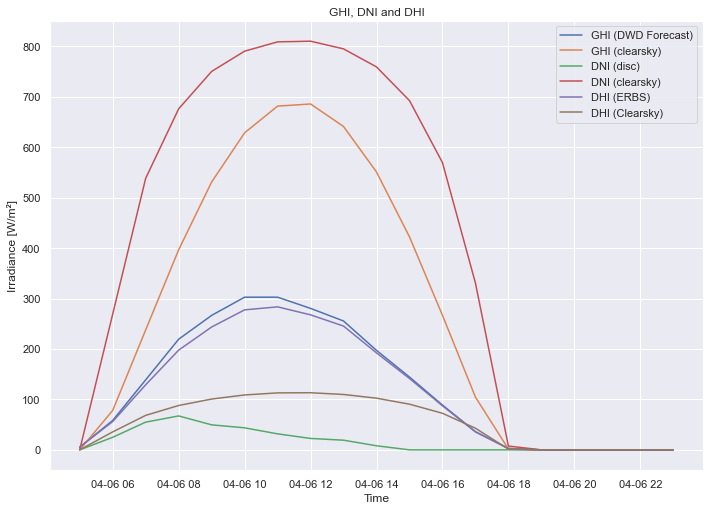

In [18]:
fig, ax = plt.subplots()
ax.set_xlabel("Time") 
ax.set_ylabel("Irradiance [W/m²]")
ax.set_title("GHI, DNI and DHI")
sns.lineplot(x=forecast_h.index, y="RAD_WH", data=forecast_h, label="GHI (DWD Forecast)")
sns.lineplot(x=forecast_h.index, y="GHI_CLEARSKY", data=forecast_h, label="GHI (clearsky)")
sns.lineplot(x=forecast_h.index, y="DNI_DISC", data=forecast_h, label="DNI (disc)")
sns.lineplot(x=forecast_h.index, y="DNI_CLEARSKY", data=forecast_h, label="DNI (clearsky)")
#sns.lineplot(x=forecast_h.index, y="DNI_DIRINDEX", data=forecast_h, label="DNI (dirindex)")

sns.lineplot(x=forecast_h.index, y="DHI_ERBS", data=forecast_h, label="DHI (ERBS)")
sns.lineplot(x=forecast_h.index, y="DHI_CLEARSKY", data=forecast_h, label="DHI (Clearsky)")



<AxesSubplot:title={'center':'Effective Irradiance'}, xlabel='Time', ylabel='Irradiance [W/m²]'>

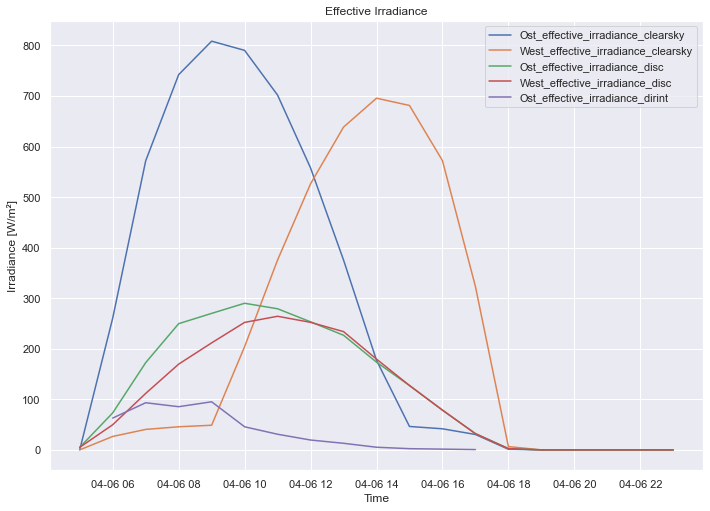

In [19]:
fig, ax = plt.subplots()
ax.set_xlabel("Time") 
ax.set_ylabel("Irradiance [W/m²]")
ax.set_title("Effective Irradiance")
sns.lineplot(x=forecast_h.index, y="Ost_effective_irradiance_clearsky", data=forecast_h, label="Ost_effective_irradiance_clearsky")
sns.lineplot(x=forecast_h.index, y="West_effective_irradiance_clearsky", data=forecast_h, label="West_effective_irradiance_clearsky")
sns.lineplot(x=forecast_h.index, y="Ost_effective_irradiance_disc", data=forecast_h, label="Ost_effective_irradiance_disc")
sns.lineplot(x=forecast_h.index, y="West_effective_irradiance_disc", data=forecast_h, label="West_effective_irradiance_disc")
sns.lineplot(x=forecast_h.index, y="Ost_effective_irradiance_dirint", data=forecast_h, label="Ost_effective_irradiance_dirint")
#sns.lineplot(x=forecast_h.index, y="West_effective_irradiance_dirint", data=forecast_h, label="West_effective_irradiance_dirint")

<AxesSubplot:title={'center':'East String'}, xlabel='Time', ylabel='Irradiance [W/m²]'>

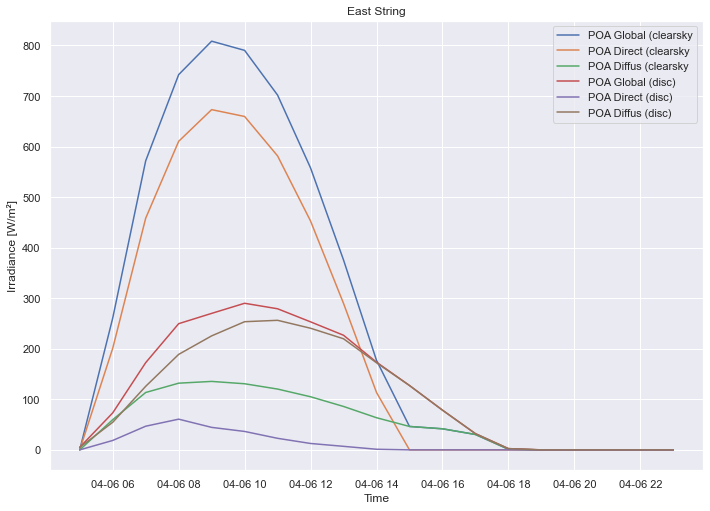

In [20]:
fig, ax = plt.subplots()
ax.set_xlabel("Time") 
ax.set_ylabel("Irradiance [W/m²]")
ax.set_title("East String")
sns.lineplot(x=forecast_h.index, y="Ost_total_irrad_poa_global_clearsky", data=forecast_h, label="POA Global (clearsky")
sns.lineplot(x=forecast_h.index, y="Ost_total_irrad_poa_direct_clearsky", data=forecast_h, label="POA Direct (clearsky")
sns.lineplot(x=forecast_h.index, y="Ost_total_irrad_poa_diffuse_clearsky", data=forecast_h, label="POA Diffus (clearsky")

sns.lineplot(x=forecast_h.index, y="Ost_total_irrad_poa_global_disc", data=forecast_h, label="POA Global (disc)")
sns.lineplot(x=forecast_h.index, y="Ost_total_irrad_poa_direct_disc", data=forecast_h, label="POA Direct (disc)")
sns.lineplot(x=forecast_h.index, y="Ost_total_irrad_poa_diffuse_disc", data=forecast_h, label="POA Diffus (disc)")

<AxesSubplot:title={'center':'West String'}, xlabel='Time', ylabel='Irradiance [W/m²]'>

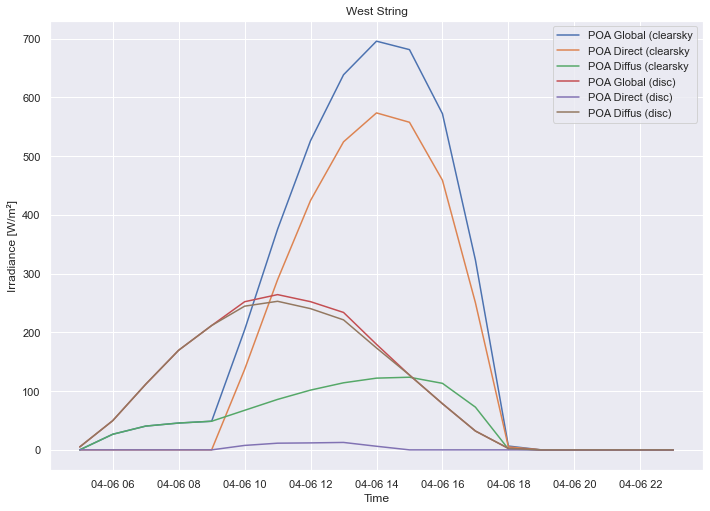

In [21]:
fig, ax = plt.subplots()
ax.set_xlabel("Time") 
ax.set_ylabel("Irradiance [W/m²]")
ax.set_title("West String")
sns.lineplot(x=forecast_h.index, y="West_total_irrad_poa_global_clearsky", data=forecast_h, label="POA Global (clearsky")
sns.lineplot(x=forecast_h.index, y="West_total_irrad_poa_direct_clearsky", data=forecast_h, label="POA Direct (clearsky")
sns.lineplot(x=forecast_h.index, y="West_total_irrad_poa_diffuse_clearsky", data=forecast_h, label="POA Diffus (clearsky")

sns.lineplot(x=forecast_h.index, y="West_total_irrad_poa_global_disc", data=forecast_h, label="POA Global (disc)")
sns.lineplot(x=forecast_h.index, y="West_total_irrad_poa_direct_disc", data=forecast_h, label="POA Direct (disc)")
sns.lineplot(x=forecast_h.index, y="West_total_irrad_poa_diffuse_disc", data=forecast_h, label="POA Diffus (disc)")

## Sun Position

<AxesSubplot:title={'center':'Angles'}, xlabel='Time', ylabel='Angle [deg]'>

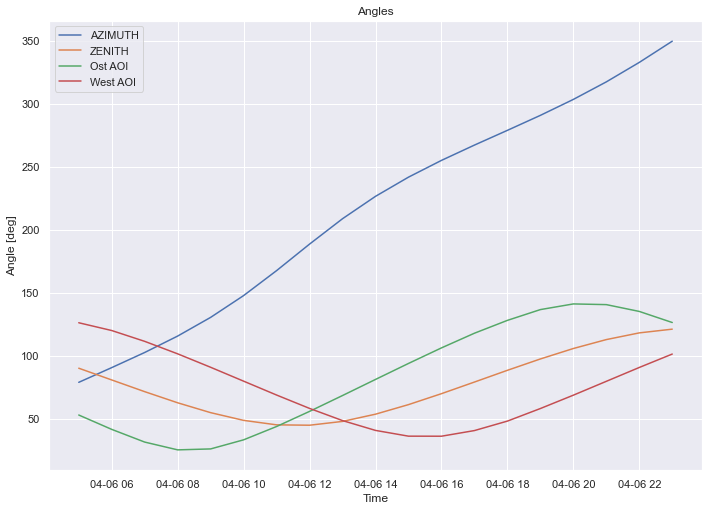

In [22]:
fig, ax = plt.subplots()
ax.set_xlabel("Time") 
ax.set_ylabel("Angle [deg]")
ax.set_title("Angles")
sns.lineplot(x=forecast_h.index, y="AZIMUTH", data=forecast_h, label="AZIMUTH")
sns.lineplot(x=forecast_h.index, y="ZENITH", data=forecast_h, label="ZENITH")
sns.lineplot(x=forecast_h.index, y="Ost_aoi_clearsky", data=forecast_h, label="Ost AOI")
sns.lineplot(x=forecast_h.index, y="West_aoi_clearsky", data=forecast_h, label="West AOI")